In [1]:
import xarray as xr
import rasterio

import pprint

# Cloud-optimized GeoTIFFs

Here's a freely available example of a nicely constructed COG from the state of Vermont.

In [2]:
url = 'https://s3.us-east-2.amazonaws.com/vtopendata-prd/Imagery/STATEWIDE_2024_30cm_LeafOFF_4Band.tif'

Check out how it looks in this cool browser-based COG mapper interface:
https://cholmes.github.io/cog-map/#/url/https%3A%2F%2Fsentinel-cogs.s3.us-west-2.amazonaws.com%2Fsentinel-s2-l2a-cogs%2F4%2FW%2FEE%2F2020%2F6%2FS2B_4WEE_20200601_1_L2A%2FB08.tif/center/-157.0548,71.3442/zoom/8.8

Let's take a quick peek at some file information. We get this via a very cheap HTTP range-request of the first few thousand kilobytes of this file, over HTTPS.

In [3]:
with rasterio.open(url) as src:
    pprint.pp(src.profile)

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 534000,
 'height': 858000,
 'count': 4,
 'crs': CRS.from_wkt('PROJCS["NAD83(2011) / Vermont",GEOGCS["NAD83(2011)",DATUM["NAD83_National_Spatial_Reference_System_2011",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6318"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",42.5],PARAMETER["central_meridian",-72.5],PARAMETER["scale_factor",0.999964286],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6589"]]'),
 'transform': Affine(0.3, 0.0, 423500.0,
       0.0, -0.3, 281400.0),
 'blockxsize': 512,
 'blockysize': 512,
 'tiled': True,
 'compress': 'jpeg',
 'interleave': 'pixel'}


Now let's open a connection to it using xarray, as we've done with numerous other files in other sessions. As always, this is reading just the metadata, and optionally preparing to chunk the data in different ways locally using Dask, depending on the `chunks` argument.

In [7]:
xr.open_dataset(url, engine='rasterio', chunks={}).band_data

# Try these too!
# xr.open_dataset(url, engine='rasterio', chunks='auto').band_data
# xr.open_dataset(url, engine='rasterio', chunks=None).band_data    # This doesn't show the same thing, but is still lazy

<xarray.DataArray 'band_data' (band: 4, y: 858000, x: 534000)> Size: 7TB
dask.array<open_dataset-band_data, shape=(4, 858000, 534000), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 4MB 4.235e+05 4.235e+05 ... 5.837e+05 5.837e+05
  * y            (y) float64 7MB 2.814e+05 2.814e+05 ... 2.4e+04 2.4e+04
    spatial_ref  int64 8B ...
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        255
    STATISTICS_MEAN:           83.417323105754
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         30.195962878872
    STATISTICS_VALID_PERCENT:  100

If you use the `load_dataset()` method, it is no longer lazy and it will force the download of all the data.

As expected with a COG file, the data provider has prepared _overviews_, referred to as _Reduced-Resolution Subfiles_ in the specification. Let's see what overviews exist in the file, using `rasterio`. This information all still comes from the file header. Metadata up front!

In [8]:
with rasterio.open(url) as src:
    print(f'Band 1 overviews: {src.overviews(1)}')
    print(f'Band 2 overviews: {src.overviews(2)}')
    print(f'Band 3 overviews: {src.overviews(3)}')
    print(f'Band 4 overviews: {src.overviews(4)}')

Band 1 overviews: [2, 4, 8, 16, 32, 64, 128, 256, 512, 1025, 2054]
Band 2 overviews: [2, 4, 8, 16, 32, 64, 128, 256, 512, 1025, 2054]
Band 3 overviews: [2, 4, 8, 16, 32, 64, 128, 256, 512, 1025, 2054]
Band 4 overviews: [2, 4, 8, 16, 32, 64, 128, 256, 512, 1025, 2054]


Now we'll lazily open the data at the first level overview. Notice the difference in dimension and total size compared to the full resolution raster.

In [9]:
xr.open_dataset(url, engine='rasterio', chunks={}, open_kwargs={"overview_level": 0})

# This is basically dispatching to rioxarray's open_rasterio() function, with Dask chunking:
#  rioxarray.open_rasterio(url, overview_level=8)

<xarray.Dataset> Size: 2TB
Dimensions:      (band: 4, x: 267000, y: 429000)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 2MB 4.235e+05 4.235e+05 ... 5.837e+05 5.837e+05
  * y            (y) float64 3MB 2.814e+05 2.814e+05 ... 2.4e+04 2.4e+04
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 2TB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

Now let's jump to level 8...

In [10]:
vt_level8 = xr.open_dataset(url, engine='rasterio', chunks={}, open_kwargs={"overview_level": 8})
vt_level8

<xarray.Dataset> Size: 28MB
Dimensions:      (band: 4, x: 1042, y: 1675)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 8kB 4.236e+05 4.237e+05 ... 5.835e+05 5.836e+05
  * y            (y) float64 13kB 2.813e+05 2.812e+05 ... 2.423e+04 2.408e+04
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 28MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

Remember that when we use xarray to read in a GeoTIFF, the `rio` attribute is our handle into the `rasterio` geospatial raster functionality that extends beyond what xarray provides for general n-dimensional arrays. Here we can print out the coordinate reference system.

In [11]:
print(vt_level8.rio.crs)

EPSG:6589


... and now transform this raster into the WGS84 CRS. Because this is outside the scope of `xarray`, this is no longer lazy and will download the data.

In [12]:
vt_level8_wgs84 = vt_level8.rio.reproject("EPSG:4326")

Let's have a quick look at the map! Yep, looks like Vermont.

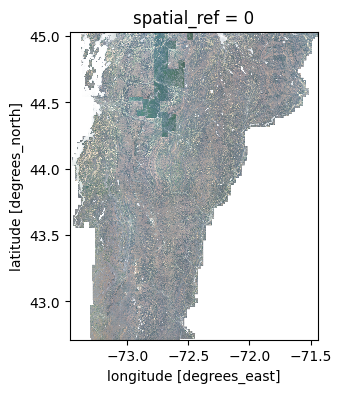

In [13]:
vt_level8_wgs84.band_data.plot.imshow(size=4, aspect=0.8, robust=True);

Lastly, just for the exercise, let's create a bounding box (in coordinates of the source CRS) for a small area within the state, and retrieve the corresponding small subset of data at full resolution. Then we'll reproject the retrieved data into WGS84, and visualize it.

Note that we have to clip before we reproject. Otherwise we'd be applying the transformation to the full high resolution dataset, and because this operation falls out side the core xarray+Dask parallelization capability, it requirezs materializing (hence downloading) all of the data.

By doing it the way we do it here, the `rasterio` engine can get the clipped data quickly from the large COG file by issuing relevant HTTP range requests.

In [14]:
import shapely
import pyproj

bbox_6589 = {
        'type': 'Polygon',
        'coordinates': [[
            [480000, 220000],
            [480000, 235000],
            [485000, 235000],
            [485000, 220000],
            [480000, 220000]
        ]]
    }

vt_level5 = xr.open_dataset(url, engine='rasterio', chunks={},
                            open_kwargs={"overview_level": 5})
vt_level5_clipped = vt_level5.rio.clip([bbox_6589])
vt_level5_wgs84_clipped = vt_level5_clipped.rio.reproject("EPSG:4326")
vt_level5_wgs84_clipped

<xarray.Dataset> Size: 4MB
Dimensions:      (x: 351, y: 746, band: 4)
Coordinates:
  * x            (x) float64 3kB -72.75 -72.75 -72.75 ... -72.69 -72.69 -72.69
  * y            (y) float64 6kB 44.61 44.61 44.61 44.61 ... 44.48 44.48 44.48
  * band         (band) int64 32B 1 2 3 4
    spatial_ref  int64 8B 0
Data variables:
    band_data    (band, y, x) float32 4MB nan nan nan nan ... nan nan nan nan

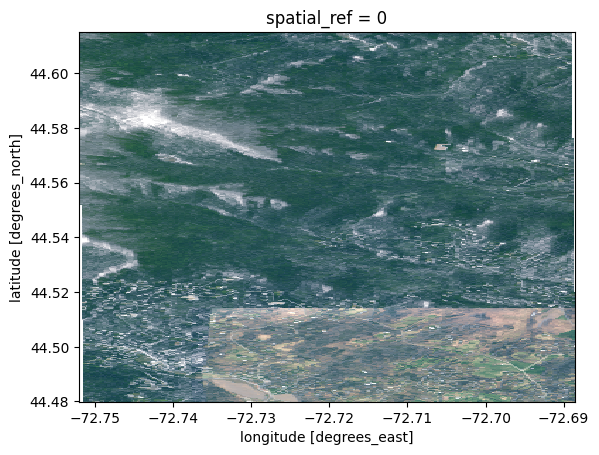

In [15]:
vt_level5_wgs84_clipped.band_data.plot.imshow(robust=True);

The axis labels come from the projection, not necessarily the original file metadata. See the below plot:

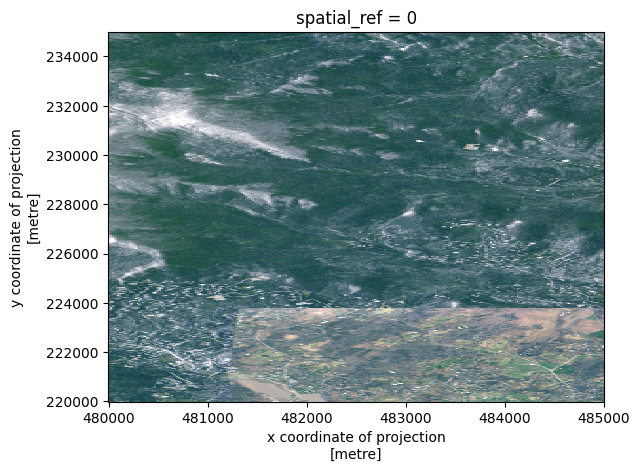

In [16]:
vt_level5_clipped.band_data.plot.imshow(robust=True);